### 1. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import *

In [2]:
df = pd.read_csv('online_clean.csv', sep='|')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685559 entries, 0 to 685558
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Invoice       685559 non-null  int64  
 1   StockCode     685559 non-null  object 
 2   Description   685559 non-null  object 
 3   Quantity      685559 non-null  int64  
 4   Invoice_time  685559 non-null  object 
 5   Price         685559 non-null  float64
 6   CustomerID    685559 non-null  float64
 7   Country       685559 non-null  object 
 8   Purchase_dt   685559 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 47.1+ MB


In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,Invoice_time,Price,CustomerID,Country,Purchase_dt
0,493414,21844,RETRO SPOT MUG,36,2010-01-04 10:28,2.55,14590.0,United Kingdom,2010-01-04
1,493414,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-04 10:28,4.25,14590.0,United Kingdom,2010-01-04
2,493414,37508,NEW ENGLAND CERAMIC CAKE SERVER,2,2010-01-04 10:28,2.55,14590.0,United Kingdom,2010-01-04
3,493414,35001G,HAND OPEN SHAPE GOLD,2,2010-01-04 10:28,4.25,14590.0,United Kingdom,2010-01-04
4,493414,21527,RETRO SPOT TRADITIONAL TEAPOT,12,2010-01-04 10:28,6.95,14590.0,United Kingdom,2010-01-04


In [5]:
df.describe()

,Invoice,Quantity,Price,CustomerID
count,685559.000000,685559.000000,685559.000000,685559.000000
mean,538198.512491,12.206345,3.065152,15549.313794
std,26358.342430,144.972907,25.869565,1592.359000
min,491148.000000,1.000000,0.000000,12346.000000
25%,515884.000000,2.000000,1.250000,14194.000000
50%,537206.000000,4.000000,1.950000,15547.000000
75%,562276.000000,12.000000,3.750000,16931.000000
max,581586.000000,80995.000000,10953.500000,18287.000000


In [6]:
df.nunique()

Invoice         32791
StockCode        4570
Description      5193
Quantity          402
Invoice_time    30868
Price             551
CustomerID       5305
Country             1
Purchase_dt       595
dtype: int64

pandas.to_datetime() convert object to date:

In [7]:
df['Purchase_dt'] = pd.to_datetime(df['Purchase_dt'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685559 entries, 0 to 685558
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Invoice       685559 non-null  int64         
 1   StockCode     685559 non-null  object        
 2   Description   685559 non-null  object        
 3   Quantity      685559 non-null  int64         
 4   Invoice_time  685559 non-null  object        
 5   Price         685559 non-null  float64       
 6   CustomerID    685559 non-null  float64       
 7   Country       685559 non-null  object        
 8   Purchase_dt   685559 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 47.1+ MB


check date range:

In [9]:
(df['Purchase_dt'].min(),df['Purchase_dt'].max())

(Timestamp('2010-01-04 00:00:00'), Timestamp('2011-12-23 00:00:00'))

extract year-month:

In [10]:
df['PurchaseMonth'] = df['Purchase_dt'].dt.to_period('M')
df.head()

,Invoice,StockCode,Description,Quantity,Invoice_time,Price,CustomerID,Country,Purchase_dt,PurchaseMonth
0,493414,21844,RETRO SPOT MUG,36,2010-01-04 10:28,2.55,14590.0,United Kingdom,2010-01-04,2010-01
1,493414,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-04 10:28,4.25,14590.0,United Kingdom,2010-01-04,2010-01
2,493414,37508,NEW ENGLAND CERAMIC CAKE SERVER,2,2010-01-04 10:28,2.55,14590.0,United Kingdom,2010-01-04,2010-01
3,493414,35001G,HAND OPEN SHAPE GOLD,2,2010-01-04 10:28,4.25,14590.0,United Kingdom,2010-01-04,2010-01
4,493414,21527,RETRO SPOT TRADITIONAL TEAPOT,12,2010-01-04 10:28,6.95,14590.0,United Kingdom,2010-01-04,2010-01


In [11]:
df['CohortMonth'] = df.groupby('CustomerID')['PurchaseMonth'].transform('min')
df.tail()

,Invoice,StockCode,Description,Quantity,Invoice_time,Price,CustomerID,Country,Purchase_dt,PurchaseMonth,CohortMonth
685554,493407,21993,FLORAL FOLK STATIONERY SET,1,2011-12-23 16:04,2.95,17867.0,United Kingdom,2011-12-23,2011-12,2010-01
685555,493407,21992,VINTAGE PAISLEY STATIONERY SET,1,2011-12-23 16:04,2.95,17867.0,United Kingdom,2011-12-23,2011-12,2010-01
685556,493407,21991,BOHEMIAN COLLAGE STATIONERY SET,1,2011-12-23 16:04,2.95,17867.0,United Kingdom,2011-12-23,2011-12,2010-01
685557,493407,21034,REX CASH+CARRY JUMBO SHOPPER,10,2011-12-23 16:04,0.95,17867.0,United Kingdom,2011-12-23,2011-12,2010-01
685558,493409,20747,PICCADILLY TEA SET,48,2011-12-23 16:58,12.75,17819.0,United Kingdom,2011-12-23,2011-12,2010-02


### 2. Cohort Analysis

create cohort index that holds total month difference between purchase month and cohort month:

In [12]:
def diff_month(x):

    d1 = x['PurchaseMonth']

    d2 = x['CohortMonth']

    return ((d1.year - d2.year) * 12 + d1.month - d2.month) + 1


df['CohortIndex'] = df.apply(lambda x: diff_month(x), axis = 1)

df

,Invoice,StockCode,Description,Quantity,Invoice_time,Price,CustomerID,Country,Purchase_dt,PurchaseMonth,CohortMonth,CohortIndex
0,493414,21844,RETRO SPOT MUG,36,2010-01-04 10:28,2.55,14590.0,United Kingdom,2010-01-04,2010-01,2010-01,1
1,493414,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-04 10:28,4.25,14590.0,United Kingdom,2010-01-04,2010-01,2010-01,1
2,493414,37508,NEW ENGLAND CERAMIC CAKE SERVER,2,2010-01-04 10:28,2.55,14590.0,United Kingdom,2010-01-04,2010-01,2010-01,1
3,493414,35001G,HAND OPEN SHAPE GOLD,2,2010-01-04 10:28,4.25,14590.0,United Kingdom,2010-01-04,2010-01,2010-01,1
4,493414,21527,RETRO SPOT TRADITIONAL TEAPOT,12,2010-01-04 10:28,6.95,14590.0,United Kingdom,2010-01-04,2010-01,2010-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...
685554,493407,21993,FLORAL FOLK STATIONERY SET,1,2011-12-23 16:04,2.95,17867.0,United Kingdom,2011-12-23,2011-12,2010-01,24
685555,493407,21992,VINTAGE PAISLEY STATIONERY SET,1,2011-12-23 16:04,2.95,17867.0,United Kingdom,2011-12-23,2011-12,2010-01,24
685556,493407,21991,BOHEMIAN COLLAGE STATIONERY SET,1,2011-12-23 16:04,2.95,17867.0,United Kingdom,2011-12-23,2011-12,2010-01,24
685557,493407,21034,REX CASH+CARRY JUMBO SHOPPER,10,2011-12-23 16:04,0.95,17867.0,United Kingdom,2011-12-23,2011-12,2010-01,24


count monthly active customers from each cohort:

In [13]:
grouping = df.groupby(['CohortMonth', 'CohortIndex'])

cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

cohort_data

CohortMonth  CohortIndex
2010-01      1              662
             2              242
             3              315
             4              294
             5              261
                           ... 
2011-10      2               64
             3               32
2011-11      1              179
             2               27
2011-12      1               60
Name: CustomerID, Length: 300, dtype: int64

return pivot table shows the absolute value per cohort per month:

In [14]:
cohort_data = cohort_data.reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')

cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-01,662.0,242.0,315.0,294.0,261.0,287.0,264.0,251.0,257.0,292.0,...,207.0,178.0,229.0,205.0,196.0,193.0,225.0,201.0,263.0,255.0
2010-02,471.0,133.0,127.0,160.0,144.0,124.0,112.0,166.0,152.0,165.0,...,88.0,117.0,95.0,98.0,93.0,135.0,124.0,113.0,101.0,NaN
2010-03,536.0,124.0,138.0,146.0,130.0,123.0,145.0,186.0,183.0,92.0,...,114.0,105.0,106.0,93.0,110.0,124.0,140.0,101.0,NaN,NaN
2010-04,331.0,66.0,71.0,63.0,65.0,74.0,97.0,99.0,48.0,30.0,...,49.0,50.0,42.0,55.0,59.0,71.0,52.0,NaN,NaN,NaN
2010-05,276.0,48.0,51.0,50.0,48.0,72.0,67.0,43.0,17.0,22.0,...,25.0,31.0,45.0,49.0,46.0,31.0,NaN,NaN,NaN,NaN
2010-06,272.0,44.0,53.0,59.0,65.0,83.0,37.0,21.0,23.0,36.0,...,29.0,30.0,38.0,61.0,26.0,NaN,NaN,NaN,NaN,NaN
2010-07,180.0,29.0,33.0,51.0,51.0,28.0,19.0,22.0,22.0,20.0,...,33.0,30.0,43.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,166.0,33.0,48.0,50.0,27.0,22.0,14.0,22.0,19.0,21.0,...,30.0,29.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,233.0,54.0,56.0,29.0,21.0,23.0,33.0,22.0,29.0,31.0,...,41.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


retention rate table:

In [15]:
cohort_size = cohort_counts.iloc[:,0] # extract the first column

retention = cohort_counts.divide(cohort_size,axis=0) # divide along the row axis 

retention.round(3) * 100 # to show the number as percentage 

CohortIndex,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-01,100.0,36.6,47.6,44.4,39.4,43.4,39.9,37.9,38.8,44.1,...,31.3,26.9,34.6,31.0,29.6,29.2,34.0,30.4,39.7,38.5
2010-02,100.0,28.2,27.0,34.0,30.6,26.3,23.8,35.2,32.3,35.0,...,18.7,24.8,20.2,20.8,19.7,28.7,26.3,24.0,21.4,NaN
2010-03,100.0,23.1,25.7,27.2,24.3,22.9,27.1,34.7,34.1,17.2,...,21.3,19.6,19.8,17.4,20.5,23.1,26.1,18.8,NaN,NaN
2010-04,100.0,19.9,21.5,19.0,19.6,22.4,29.3,29.9,14.5,9.1,...,14.8,15.1,12.7,16.6,17.8,21.5,15.7,NaN,NaN,NaN
2010-05,100.0,17.4,18.5,18.1,17.4,26.1,24.3,15.6,6.2,8.0,...,9.1,11.2,16.3,17.8,16.7,11.2,NaN,NaN,NaN,NaN
2010-06,100.0,16.2,19.5,21.7,23.9,30.5,13.6,7.7,8.5,13.2,...,10.7,11.0,14.0,22.4,9.6,NaN,NaN,NaN,NaN,NaN
2010-07,100.0,16.1,18.3,28.3,28.3,15.6,10.6,12.2,12.2,11.1,...,18.3,16.7,23.9,11.1,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,100.0,19.9,28.9,30.1,16.3,13.3,8.4,13.3,11.4,12.7,...,18.1,17.5,11.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,100.0,23.2,24.0,12.4,9.0,9.9,14.2,9.4,12.4,13.3,...,17.6,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


build the heatmap:

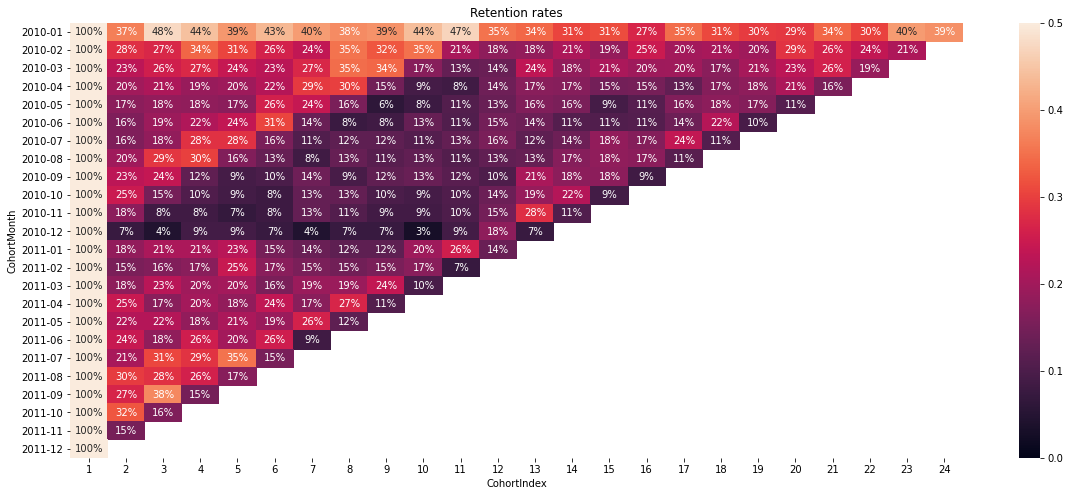

In [16]:
plt.figure(figsize = (20, 8))

plt.title('Retention rates')

sns.heatmap(data = retention, annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5)

plt.show()

We can see the churn rates of customers acquired before December of 2010 sharply increased in this month, and customers acquired in this month were much less likely to return, which is something should grab the attention. 

### 3. Recency, Frequency and Monetary (RFM) Analysis

In [17]:
df_copy = df.copy()

In [18]:
df_copy['Sales'] = df_copy['Quantity']*df_copy['Price']

##### Recency

define "current":

In [19]:
df_copy.loc[:,'current'] = pd.to_datetime('2011-12-23')

calculate the range:

In [20]:
df_copy['range'] = df_copy['current'] - df_copy['Purchase_dt']

return the minimum range for each customer:

In [21]:
df_copy.groupby('CustomerID')['range'].min()

CustomerID
12346.0   339 days
12608.0   418 days
12745.0   500 days
12746.0   554 days
12747.0     7 days
            ...   
18283.0    17 days
18284.0   445 days
18285.0   674 days
18286.0     7 days
18287.0    56 days
Name: range, Length: 5305, dtype: timedelta64[ns]

##### Frequency

In [22]:
df_copy.groupby('CustomerID')['Invoice'].nunique()

CustomerID
12346.0     3
12608.0     1
12745.0     2
12746.0     1
12747.0    24
           ..
18283.0    22
18284.0     1
18285.0     1
18286.0     2
18287.0     7
Name: Invoice, Length: 5305, dtype: int64

##### Monetary

In [23]:
df_copy.groupby('CustomerID')['Sales'].sum()

CustomerID
12346.0    77352.96
12608.0      415.79
12745.0      723.85
12746.0      254.55
12747.0     8214.63
             ...   
18283.0     2664.90
18284.0      461.68
18285.0      427.00
18286.0     1296.43
18287.0     4182.99
Name: Sales, Length: 5305, dtype: float64

##### RFM Dataframe

In [24]:
rfm = df_copy.groupby('CustomerID').agg(recency=pd.NamedAgg(column='range', aggfunc='min'),
                                                  frequency=pd.NamedAgg(column='Invoice', aggfunc='nunique'),
                                                  monetary=pd.NamedAgg(column='Sales', aggfunc='sum')
                                                 ).reset_index()

In [25]:
rfm['recency']=rfm['recency']/np.timedelta64(1, 'D')
rfm.head()

,CustomerID,recency,frequency,monetary
0,12346.0,339.0,3,77352.96
1,12608.0,418.0,1,415.79
2,12745.0,500.0,2,723.85
3,12746.0,554.0,1,254.55
4,12747.0,7.0,24,8214.63


create RFM score:

In [26]:
rfm['r_percentile'] = rfm['recency'].rank(method='first',pct=True,ascending=True)
rfm['r_score'] = pd.qcut(rfm['r_percentile'], 4, labels=range(4,0,-1))

rfm['m_percentile'] = rfm['monetary'].rank(method='first', pct=True,ascending=False)
rfm['m_score'] = pd.qcut(rfm['m_percentile'], 4, labels=range(4,0,-1))

rfm['f_percentile'] = rfm['frequency'].rank(method='first',pct=True,ascending=False)
rfm['f_score'] = rfm['frequency'].apply(
    lambda x: 1 if x <= 1 else 2 if x <= 5 \
        else 3 if x <= 10 else 4)

rfm.head()

,CustomerID,recency,frequency,monetary,r_percentile,r_score,m_percentile,m_score,f_percentile,f_score
0,12346.0,339.0,3,77352.96,0.734402,2,0.002828,4,0.448445,2
1,12608.0,418.0,1,415.79,0.812441,1,0.683883,2,0.723091,1
2,12745.0,500.0,2,723.85,0.894062,1,0.540057,2,0.562677,2
3,12746.0,554.0,1,254.55,0.920264,1,0.812441,1,0.723280,1
4,12747.0,7.0,24,8214.63,0.034307,4,0.054288,4,0.037135,4


In [27]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5305 entries, 0 to 5304
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   CustomerID    5305 non-null   float64 
 1   recency       5305 non-null   float64 
 2   frequency     5305 non-null   int64   
 3   monetary      5305 non-null   float64 
 4   r_percentile  5305 non-null   float64 
 5   r_score       5305 non-null   category
 6   m_percentile  5305 non-null   float64 
 7   m_score       5305 non-null   category
 8   f_percentile  5305 non-null   float64 
 9   f_score       5305 non-null   int64   
dtypes: category(2), float64(6), int64(2)
memory usage: 342.3 KB


In [28]:
rfm['r_score']=rfm['r_score'].astype(int)

rfm['m_score']=rfm['m_score'].astype(int)

rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

rfm.head()

,CustomerID,recency,frequency,monetary,r_percentile,r_score,m_percentile,m_score,f_percentile,f_score,rfm_score
0,12346.0,339.0,3,77352.96,0.734402,2,0.002828,4,0.448445,2,8
1,12608.0,418.0,1,415.79,0.812441,1,0.683883,2,0.723091,1,4
2,12745.0,500.0,2,723.85,0.894062,1,0.540057,2,0.562677,2,5
3,12746.0,554.0,1,254.55,0.920264,1,0.812441,1,0.723280,1,3
4,12747.0,7.0,24,8214.63,0.034307,4,0.054288,4,0.037135,4,12


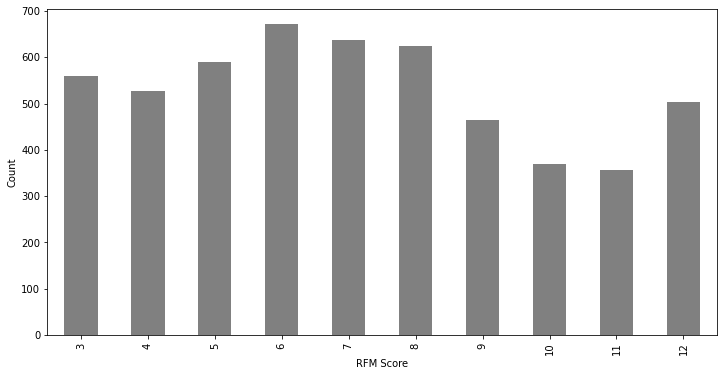

In [29]:
ax = rfm['rfm_score'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), color = 'grey')

ax.set_xlabel("RFM Score")

ax.set_ylabel("Count")

plt.show()

In [30]:
rfm['Segment'] = 'Low-Value'

rfm.loc[rfm['rfm_score']>5,'Segment'] = 'Mid-Value' 

rfm.loc[rfm['rfm_score']>9,'Segment'] = 'High-Value'

rfm

,CustomerID,recency,frequency,monetary,r_percentile,r_score,m_percentile,m_score,f_percentile,f_score,rfm_score,Segment
0,12346.0,339.0,3,77352.96,0.734402,2,0.002828,4,0.448445,2,8,Mid-Value
1,12608.0,418.0,1,415.79,0.812441,1,0.683883,2,0.723091,1,4,Low-Value
2,12745.0,500.0,2,723.85,0.894062,1,0.540057,2,0.562677,2,5,Low-Value
3,12746.0,554.0,1,254.55,0.920264,1,0.812441,1,0.723280,1,3,Low-Value
4,12747.0,7.0,24,8214.63,0.034307,4,0.054288,4,0.037135,4,12,High-Value
...,...,...,...,...,...,...,...,...,...,...,...,...
5300,18283.0,17.0,22,2664.90,0.135156,4,0.205467,4,0.046560,4,12,High-Value
5301,18284.0,445.0,1,461.68,0.853534,1,0.655985,2,0.999811,1,4,Low-Value
5302,18285.0,674.0,1,427.00,0.983977,1,0.675966,2,1.000000,1,4,Low-Value
5303,18286.0,7.0,2,1296.43,0.046937,4,0.370028,3,0.722903,2,9,Mid-Value


### 4. CLV Modeling

In [31]:
df_rfm = df_copy[['Invoice','Purchase_dt','CustomerID','Sales']]
df_rfm.head()

,Invoice,Purchase_dt,CustomerID,Sales
0,493414,2010-01-04,14590.0,91.8
1,493414,2010-01-04,14590.0,51.0
2,493414,2010-01-04,14590.0,5.1
3,493414,2010-01-04,14590.0,8.5
4,493414,2010-01-04,14590.0,83.4


In [32]:
df_rfm['CustomerID'] = df_rfm['CustomerID'].astype('object')

In [33]:
df_clv = summary_data_from_transaction_data(df_rfm,'CustomerID','Purchase_dt', monetary_value_col='Sales', 
                                            observation_period_end='2011-12-23')
df_clv.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,2.0,322.0,661.0,38662.955000
12608.0,0.0,0.0,418.0,0.000000
12745.0,1.0,88.0,588.0,266.930000
12746.0,0.0,0.0,554.0,0.000000
12747.0,23.0,674.0,681.0,353.274348


Basic Frequency/Recency analysis using the BG/NBD model

In [34]:
bgf = BetaGeoFitter(penalizer_coef=0.0)

bgf.fit(df_clv['frequency'],df_clv['recency'],df_clv['T'])

bgf

<lifetimes.BetaGeoFitter: fitted with 5305 subjects, a: 0.08, alpha: 67.33, b: 1.80, r: 0.68>

##### Visualizing Frequency/Recency Matrix

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

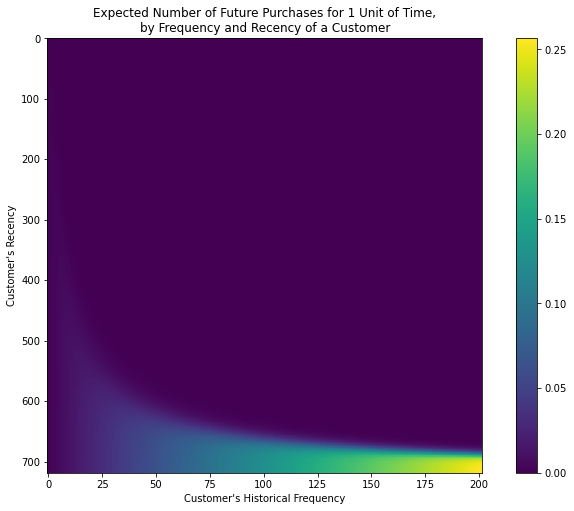

In [35]:
fig = plt.figure(figsize=(12,8))

plot_frequency_recency_matrix(bgf)

- We can see that if a customer has bought 200 times, and their latest purchase was when they were 700 days old (given the individual is 700 days old), then they are best customer (bottom-right). 

- The coldest customers are those that are in the top-right corner: they bought a lot quickly, and haven’t been seen in weeks.

- There’s also that beautiful “tail” around (25,600). That represents the customer who buys infrequently, but have been seen recently, so they might buy again - we’re not sure if they are "dead" or just between purchases.

##### Matrix to look at is the probability of still being "alive"

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

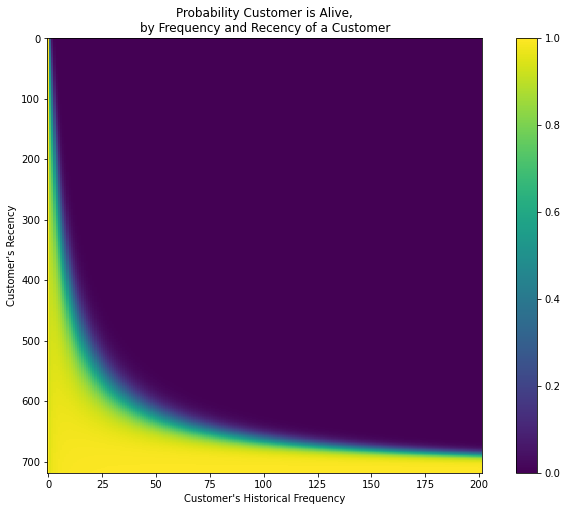

In [36]:
fig = plt.figure(figsize=(12,8))

plot_probability_alive_matrix(bgf)

- The customers in dark blue area are churned more probably 

- The customers in yellow area are still alive

##### Ranking customers from best to worst

Let’s return to the customers and rank them from highest expected purchases in the next period to lowest. Models expose a method that will predict a specific customer’s expected purchases in the next period using their history.

In [37]:
t = 30

df_clv['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
                                 t, df_clv['frequency'], df_clv['recency'], df_clv['T'])

df_clv.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
13089.0,129.0,710.0,712.0,861.772171,4.980574
14606.0,177.0,715.0,717.0,162.999492,6.781601
17841.0,189.0,715.0,718.0,353.720317,7.229246
15311.0,189.0,716.0,717.0,579.317989,7.240812
12748.0,201.0,706.0,708.0,264.693980,7.787133


##### Assessing model fit

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

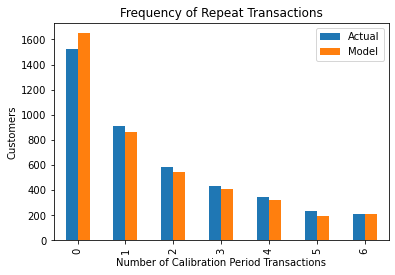

In [38]:
plot_period_transactions(bgf)

- We can assess the model’s correctness by comparing the data versus artificial data simulated with the fitted model’s parameters. 
- We can see that the actual data and the simulated data line up well. This proves that our model works.

##### Customer Predictions

In [39]:
t = 30

individual = df_clv.loc[12747]

bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.9441427664677592

- Based on history of customer 12747, we can predict the probability he/she will purchase within 30 days is 0.944.

##### Customer Probability Histories

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

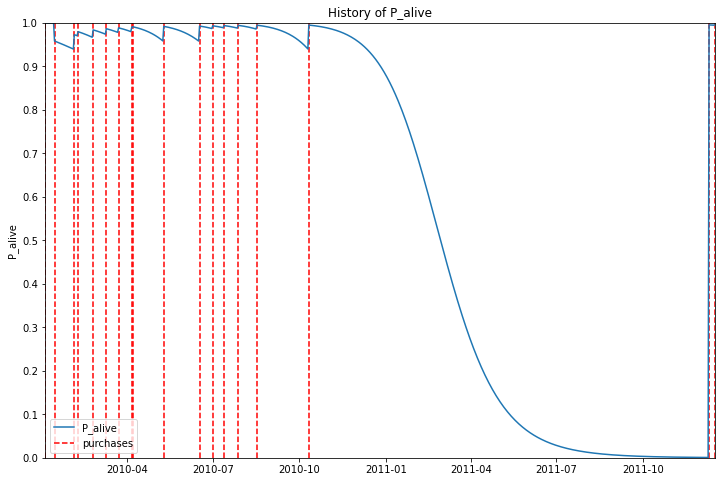

In [40]:
fig = plt.figure(figsize=(12,8))

id = 14590

days_since_birth = 700

sp_trans = df_rfm.loc[df_rfm['CustomerID'] == id]

plot_history_alive(bgf, days_since_birth, sp_trans, 'Purchase_dt')

- Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. 
- Customer 14590 is alive although he/she didn't purchase anything from Oct 2010 to Nov 2011.

##### Estimating customer lifetime value using the Gamma-Gamma model

- To estimate the economic value of each transaction, we can use the Gamma-Gamma submodel.
- The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. 
- In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [41]:
returning_customers_summary = df_clv[df_clv['frequency']>0]

returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.014681
frequency,0.014681,1.000000


At this point we can train Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers：

In [42]:
ggf = GammaGammaFitter(penalizer_coef = 0)

ggf.fit(returning_customers_summary['frequency'], returning_customers_summary['monetary_value'])

ggf.conditional_expected_average_profit(df_clv['frequency'], df_clv['monetary_value']).head(10)

CustomerID
12346.0    23912.583080
12608.0      376.998607
12745.0      328.154181
12746.0      376.998607
12747.0      354.500451
12748.0      265.389981
12749.0      901.227339
12777.0      376.998607
12819.0      376.998607
12820.0      261.256380
dtype: float64

While for computing the total CLV using the DCF (Discounted Cash Flow) method adjusting for cost of capital:

In [43]:
bgf.fit(df_clv['frequency'], df_clv['recency'], df_clv['T'])

predicted_value = ggf.customer_lifetime_value( 
    bgf, # the model to use to predict the number of future transactions 
    df_clv['frequency'], 
    df_clv['recency'],
    df_clv['T'],
    df_clv['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).reset_index()

predicted_value.head(10)

,CustomerID,clv
0,12346.0,25473.722137
1,12608.0,175.618805
2,12745.0,187.904748
3,12746.0,137.726902
4,12747.0,3713.327773
5,12748.0,22936.278233
6,12749.0,3268.015950
7,12777.0,158.607851
8,12819.0,158.318575
9,12820.0,1073.105670
